In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [113]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(96, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.STL10('/files/', split='train', folds=1, download=True,
                               transform=train_transform),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.STL10('/files/', split='test', folds=1, download=True,
                               transform=test_transform),
    batch_size=64, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [114]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        # self.dropout1 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        # self.dropout2 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        # self.dropout3 = nn.Dropout(0.1)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        # x = self.dropout1(x)

        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        # x = self.dropout2(x)

        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        x = self.pool(self.relu(self.bn6(self.conv6(x))))
        # x = self.dropout3(x)

        x = self.global_avg_pool(x)
        x = x.view(-1, 512)

        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = NN()

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00003)


In [116]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy

def test(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return running_loss / len(loader), accuracy


In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch 1/100, Train Loss: 2.2743, Train Accuracy: 13.70%, Test Loss: 2.3016, Test Accuracy: 10.04%
Epoch 2/100, Train Loss: 2.2081, Train Accuracy: 21.00%, Test Loss: 2.2265, Test Accuracy: 23.31%
Epoch 3/100, Train Loss: 2.1602, Train Accuracy: 22.50%, Test Loss: 2.0950, Test Accuracy: 28.14%
Epoch 4/100, Train Loss: 2.0936, Train Accuracy: 24.50%, Test Loss: 2.0226, Test Accuracy: 28.80%
Epoch 5/100, Train Loss: 2.0355, Train Accuracy: 27.00%, Test Loss: 1.9462, Test Accuracy: 34.01%
Epoch 6/100, Train Loss: 1.9910, Train Accuracy: 27.90%, Test Loss: 1.8786, Test Accuracy: 35.24%
Epoch 7/100, Train Loss: 1.9190, Train Accuracy: 34.30%, Test Loss: 1.8194, Test Accuracy: 36.14%
Epoch 8/100, Train Loss: 1.8716, Train Accuracy: 31.90%, Test Loss: 1.7578, Test Accuracy: 39.09%
Epoch 9/100, Train Loss: 1.8236, Train Accuracy: 35.10%, Test Loss: 1.6979, Test Accuracy: 41.23%
Epoch 10/100, Train Loss: 1.7695, Train Accuracy: 37.10%, Test Loss: 1.6722, Test Accuracy: 40.79%
Epoch 11/100, Train

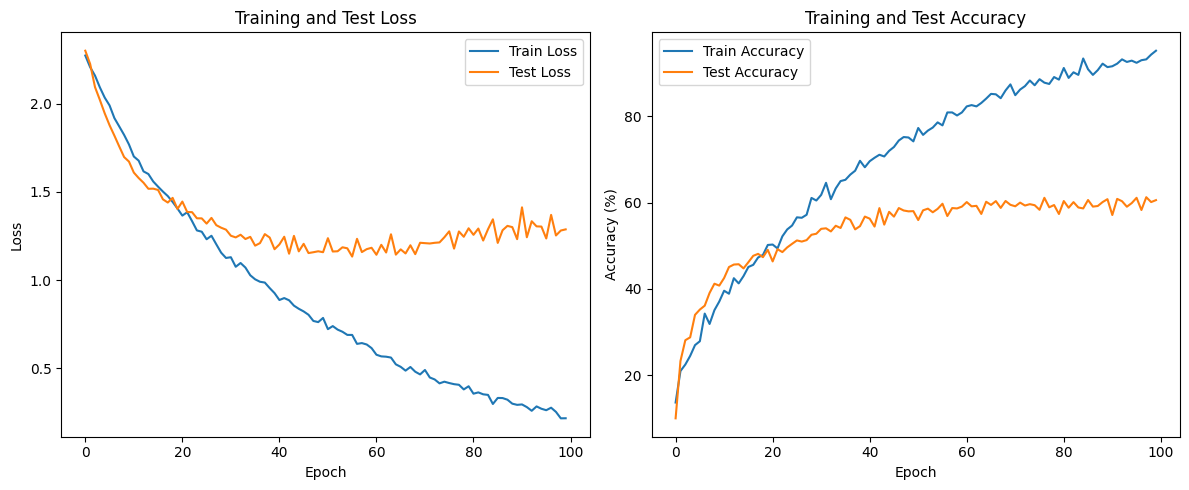

In [118]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


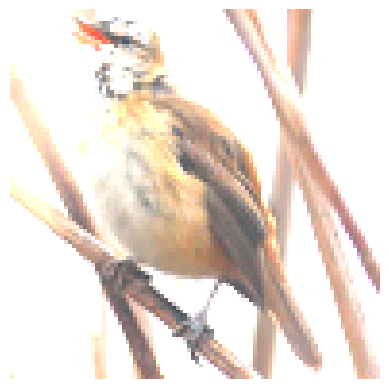

Predicted: 1, Actual: 1


In [119]:
def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

def test_random_image(model, loader, device):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    import random
    index = random.randint(0, images.size(0) - 1)
    image = images[index].unsqueeze(0)
    label = labels[index].item()

    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()

    imshow(image.cpu().squeeze())
    print(f'Predicted: {predicted}, Actual: {label}')

test_random_image(model, test_loader, device)